<a href="https://colab.research.google.com/github/LingfengChen-lc/SF_hospital_data/blob/main/Lingfeng_SF_data_VAE_generate_balanced_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
from numpy import mean
from numpy import std
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import time

In [3]:
!ls gdrive/MyDrive/ML-TRAUMA\ PROJECT/F20-TEAM\ PROGRESS/F20/F20\ Monte\ Carlo/RESULTS/

 Bellevue.csv
 Bellevue.xlsx
 Figures
'Lingfeng_SF_data_VAE_generate_balanced_dataset (1).ipynb'
 SF_IMP_ALL_OUTCOMES.csv
 SF_IMP_ALL_OUTCOMES.gsheet
 SF_IMP_MOF.csv
 SF_IMP_MORTALITY.csv
 SF_IMP_MORTALITY.gsheet
 SF_IMP_TRAUMA.csv
'SF_IMPUTED (1).gsheet'
'SF_IMPUTED (2).gsheet'
 SF_IMPUTED.csv
 SF_IMPUTED.gsheet
 SF_IMP_VTE.csv
 SF_ISS_IMP.csv
'SF_TIMESERIES (1).gsheet'
 SF_TIMESERIES.csv
 SF_TIMESERIES.gsheet
 SF_TRAUMA_IMP.csv
 SF_TRAUMA_IMP.gsheet
'Will_Imputation&SuperLearner.ipynb'
 Will_VirtualPatients.ipynb


**Import the Data**

Weekly works: 

1. visualize for comparison of accuracies
2. visualize distribution of each parameter
3. try use ony 10 epoches and test for accuracy (check, unchanged, so can use only 10 epoches to generate visuals)
  3a. Try make the graph more consistent, why cluster after 80 epoches. 
4. modify on VAE itself, and try Monte Carlo Dropouts
5. Finish GDA, try remove negative values, and visualize for distribution, compute model accuracy improvements.
6. Build a pipeline and apply cv to split-generate-test

1. Lower dimension of vae AND check for accuracy/clustering

2. Use absolute mean metrics to measure similarity between virtual and real patients

3. Try with VAE with Monte Carlo DROPS

4. look into why clustering



draw X and Y axis

experiment with sklearn GDA, alter the parameters

check accuracy

Check standard implementation of GDA, search if can model prior other than normal distribution. 

summary methods, state limitations, possible errors

MOF = 0 and mortality 0 (majority)

In [ ]:
# trauma_data = pd.read_excel('gdrive/MyDrive/ML-TRAUMA PROJECT/F20-TEAM PROGRESS/F20/F20 Monte Carlo/RESULTS/SF_IMPUTED.gsheet')
original_df = pd.read_excel('gdrive/MyDrive/SF_IMPUTED.xlsx')
original_df.drop(columns=['hr0_ptt.1', 'hr0_factorviii'], inplace=True)
original_df.loc[1201, 'hr0_temp'] = 39.0

In [ ]:
Interest_features = ['hr0_creatinine', 'hr0_wbc', 'hr0_ddimer', 'hr0_plts', 'hr0_pt', 'hr0_temp']
original_df.columns

Index(['hr0_temp', 'hr0_hr', 'hr0_resprate', 'hr0_sbp', 'hr0_ph', 'hr0_bun',
       'hr0_creatinine', 'hr0_wbc', 'hr0_hgb', 'hr0_hct', 'hr0_factorii',
       'hr0_factorv', 'hr0_factorx', 'hr0_tfpi', 'hr0_ddimer', 'hr0_pt',
       'hr0_ptt', 'hr0_inr', 'hr0_plts', 'Mortality'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f417b717c10>,
      dtype=object)

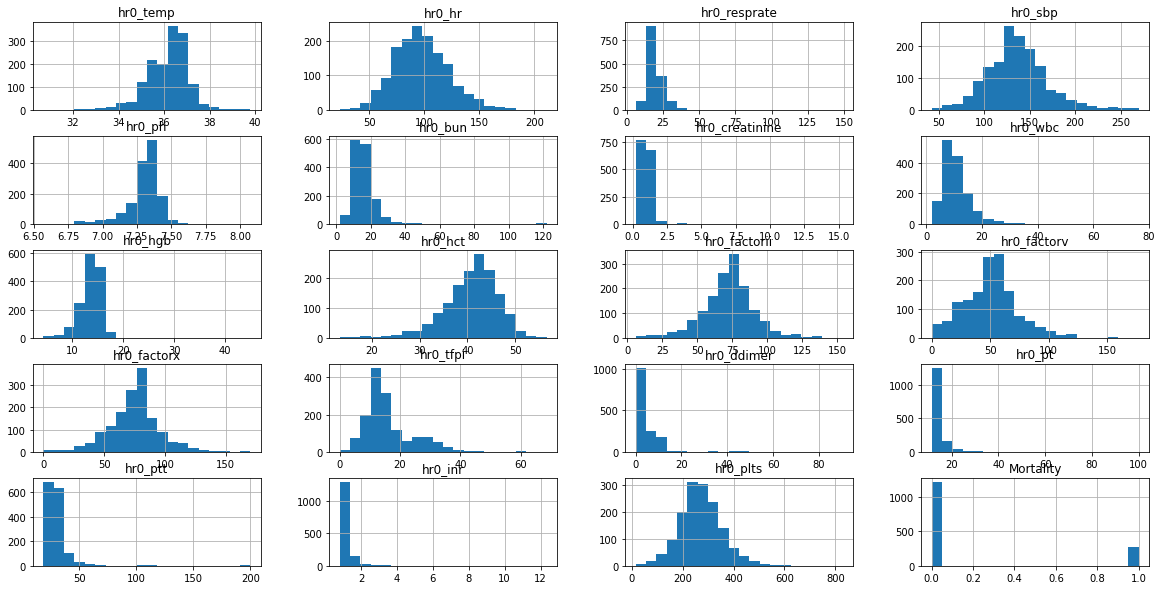

In [ ]:
original_df.hist(bins=20, figsize=(20,10))

In [ ]:
#transform certain variables to make normal distributed
features = ['hr0_temp', 'hr0_resprate', 'hr0_bun', 'hr0_creatinine', 'hr0_pt', 'hr0_ptt', 'hr0_inr']
for f in features:
  original_df[f] = np.log(original_df[f])

original_df.hist(bins=20, figsize=(20,10))

**Visualize for VAE (variational autoencoder)**
1. Train VAE
2. Use PCA to visualize data

In [ ]:
# VAE model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.layers import Lambda, Input, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
original_dim = original_df.shape[1] - 1

#code from https://github.com/KristianMiok/MCD-VAE/blob/master/New_MC_VAE_VAE_Comparision.ipynb

class VAE:
    def __init__(self, input_shape=(original_dim,), 
                 #original 17, 5
                 intermediate_dim=10, latent_dim=3, summary=False):
        
        self._build_model(input_shape,
                         intermediate_dim, 
                          latent_dim, summary)
    
    def _build_model(self, input_shape, intermediate_dim, latent_dim,
                    summary=False):
        inputs = Input(shape=input_shape, name='encoder_input')
        x = inputs
        x = Dense(intermediate_dim, activation='relu')(x)
        x = Dense(intermediate_dim//2, activation='relu')(x)
        
        z_mean = Dense(latent_dim, name='z_mean')(x)
        z_log_var = Dense(latent_dim, name='z_log_var')(x)

        z = Lambda(self.sampling, output_shape=(latent_dim,), 
                   name='z')([z_mean, z_log_var])

        self.encoder = Model(inputs, [z_mean, z_log_var, z], 
                        name='encoder')
        
        latent_inputs = Input(shape=(latent_dim,), 
                              name='z_sampling')
        x = latent_inputs
        x = Dense(intermediate_dim//2, activation='relu')(x)
        x = Dense(intermediate_dim, activation='relu')(x)
        outputs = Dense(original_dim, activation='sigmoid')(x)

        self.decoder = Model(latent_inputs, outputs, name='decoder')
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')
        
        reconstruction_loss = binary_crossentropy(inputs, outputs)
        reconstruction_loss *= original_dim
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        
        vae_loss = K.mean(reconstruction_loss + kl_loss)	
        
        self.vae.add_loss(vae_loss)
        self.vae.compile(optimizer='adam')
        if summary: 
            print(self.vae.summary())
        
    def sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
        
    def fit(self, x_train, x_test, epochs=100, batch_size=100,
           verbose=1):
        self.vae.fit(x_train, 
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            validation_data=(x_test, None))
    
    def encoder_predict(self, x_test, batch_size=100):
        return self.encoder.predict(x_test,
                                   batch_size=batch_size)
    
    def generate(self, latent_val, batch_size=100):
        return self.decoder.predict(latent_val)
    
    def predict(self, x_test, batch_size=1):
        prediction = self.vae.predict(x_test)
        return prediction


In [ ]:
# class DropoutVAE:
#     def __init__(self, input_shape=(original_dim,), 
#                  intermediate_dim=14, latent_dim=5, dropout=0.05, 
#                  summary=False):
        
#         self._build_model(input_shape,
#                          intermediate_dim, 
#                           latent_dim, summary,
#                           dropout)
    
#     def _build_model(self, input_shape, intermediate_dim, latent_dim,
#                     summary=False, dropout=0.05):
#         inputs = Input(shape=input_shape, name='encoder_input')
#         x = inputs
#         x = Dense(intermediate_dim, activation='relu')(x)
#         x = Dense(intermediate_dim//2, activation='relu')(x)
        
#         z_mean = Dense(latent_dim, name='z_mean')(x)
#         z_log_var = Dense(latent_dim, name='z_log_var')(x)
        
#         # We do not need this one
# #         z = Lambda(self.sampling, output_shape=(latent_dim,), 
# #                    name='z')([z_mean, z_log_var])
        
#         # We remove the z layer ( z layer is used in VAE but not here)
#         self.encoder = Model(inputs, [z_mean, z_log_var], 
#                         name='encoder')
        
#         latent_inputs = Input(shape=(latent_dim,), 
#                               name='z_sampling')
#         x = latent_inputs
#         x = Dense(intermediate_dim//2, activation='relu',
#                  kernel_regularizer=l2(1e-4),
#                  bias_regularizer=l2(1e-4))(x)
#         x = Dropout(dropout)(x)
#         x = Dense(intermediate_dim, activation='relu',
#                  kernel_regularizer=l2(1e-4),
#                  bias_regularizer=l2(1e-4))(x)
#         x = Dropout(dropout)(x)
#         outputs = Dense(original_dim, activation='sigmoid',
#                        kernel_regularizer=l2(1e-4),
#                        bias_regularizer=l2(1e-4))(x)

#         self.decoder = Model(latent_inputs, 
#                              outputs, 
#                              name='decoder')
        
#         # Here we take the mean (not the z-layer) 
#         outputs = self.decoder(self.encoder(inputs)[0])
#         self.vae = Model(inputs, outputs, 
#                          name='vae_mlp')
        
#         reconstruction_loss = binary_crossentropy(inputs, outputs)
#         reconstruction_loss *= original_dim 
#         kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
#         kl_loss = K.sum(kl_loss, axis=-1)
#         kl_loss *= -0.5
        
#         vae_loss = K.mean(reconstruction_loss + kl_loss)	
        
#         self.vae.add_loss(vae_loss)
#         self.vae.compile(optimizer='adam')
#         if summary: 
#             print(self.vae.summary())
        
#     def fit(self, x_train, x_test, epochs=100, batch_size=100,
#            verbose=1):
#         self.vae.fit(x_train, 
#             shuffle=True,
#             epochs=epochs,
#             batch_size=batch_size,
#             verbose=verbose,
#             validation_data=(x_test, None))
    
#     def encoder_predict(self, x_test, batch_size=100):
#         return self.encoder.predict(x_test,
#                                    batch_size=batch_size)
    
#     def generate(self, latent_val, batch_size=100):
#         return self.decoder.predict(latent_val)
    
#     def predict(self, x_test, batch_size=1, nums=1000):
#         Yt_hat = []
#         for _ in range(nums):
#             Yt_hat.extend(self.vae.predict(x_test))
                          
#         return np.asarray(Yt_hat)
                          
#     def mean_predict(self, x_test, batch_size=1, nums=1000):
#         predict_stochastic = K.function([self.decoder.layers[0].input,
#                                 K.learning_phase()],
#                                 [self.decoder.get_output_at(0)])
#         latents = self.encoder.predict(x_test)[0]
#         Yt_hat = []
#         for _ in range(nums):
#             Yt_hat.append(predict_stochastic([latents, 1])) 
#         return np.asarray(Yt_hat)

Split part of the data and use it as the final test set.

In [ ]:
trauma_data, final_test_set = train_test_split(original_df, test_size=0.2, random_state=0, shuffle=True)

In [ ]:
final_test_set.isna().sum()

hr0_temp          0
hr0_hr            0
hr0_resprate      0
hr0_sbp           0
hr0_ph            0
hr0_bun           0
hr0_creatinine    0
hr0_wbc           0
hr0_hgb           0
hr0_hct           0
hr0_factorii      0
hr0_factorv       0
hr0_factorx       0
hr0_tfpi          0
hr0_ddimer        0
hr0_pt            0
hr0_ptt           0
hr0_inr           0
hr0_plts          0
Mortality         0
dtype: int64

In [ ]:
# results_0[3].describe()
trauma_data.describe()

MOF = 0 and mortality 0 (majority)

Train VAE

In [ ]:
trauma_data.Mortality.value_counts()

0    971
1    216
Name: Mortality, dtype: int64

In [ ]:
#separate dataframe to two classes
scaler = MinMaxScaler()
def train_test_process(df):
  vae_train = scaler.fit_transform(df.values)
  x_train, x_test = train_test_split(vae_train, test_size=0.4,
                                    random_state=0,
                                    shuffle=True)
  # original_dim = x_train.shape[1]
  x_train = np.reshape(x_train, [-1, original_dim])
  x_test = np.reshape(x_test, [-1, original_dim])
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  return (x_train, x_test)
#class 0 train test set (total 971)
df_class_0 = trauma_data[trauma_data['Mortality'] == 0].drop('Mortality', axis=1)
x_train_0, x_test_0 = train_test_process(df_class_0)
#class 1 train test set (total 216)
df_class_1 = trauma_data[trauma_data['Mortality'] == 1].drop('Mortality', axis=1)
x_train_1, x_test_1 = train_test_process(df_class_1)
#respectively fit two dataframes with two VAE models
# latent_dim = 3
# intermediate_dim = 14

In [ ]:
# XX = trauma_data[trauma_data['Mortality'] == 0].drop('Mortality', axis=1)
# print(XX.describe())
# YY = scaler.fit_transform(XX.values)
# YY = pd.DataFrame(YY) 
# YY.columns = trauma_data.drop('Mortality', axis=1).columns
# print(YY.describe())
# YY = scaler.inverse_transform(YY)
# YY = pd.DataFrame(YY) 
# YY.columns = trauma_data.drop('Mortality', axis=1).columns
# print(YY.describe())


In [ ]:
# """
# play with drop outs
# """

# df_class_0 = trauma_data[trauma_data['Mortality'] == 0].drop('Mortality', axis=1)
# x_train_0, x_test_0 = train_test_process(df_class_0)
# df_class_1 = trauma_data[trauma_data['Mortality'] == 1].drop('Mortality', axis=1)
# x_train_1, x_test_1 = train_test_process(df_class_1)
# # latent_dim = 5
# # intermediate_dim = 14
# vae_drop_0 = DropoutVAE(dropout=0.2, summary=True)
# vae_drop_1 = DropoutVAE(dropout=0.2, summary=True)

In [ ]:
# vae_drop_0.fit(x_train_0, x_test_0, epochs = 150)
# vae_drop_1.fit(x_train_1, x_test_1, epochs = 150)


In [ ]:
# x_test_0 = np.reshape(x_test_0, (-1, original_dim))
# print(x_test_0.shape)
# print(x_test_0[0].reshape(-1, original_dim).shape)

# total_nums = 2
# results = []

# x_test_encoded = vae_drop_0.mean_predict(x_test_0, nums=total_nums)
# print(x_test_encoded.shape)

# results = x_test_encoded
# results = results.reshape(total_nums*results.shape[2], original_dim)
# results = scaler.inverse_transform(results)
# print(results.shape)

**Use PCA to visualize VAE process of training**

In [ ]:
# Use this to generate graphs

# Group 0 generation
# epochs_0 = [1, 10, 20, 30]
epochs_0 = [10, 50, 100, 150]
total_nums = 1
results_0 = [[],[], [], []]
for j, epoch in enumerate(epochs_0):
  vae_0 = VAE()
  vae_0.fit(x_train_0, x_test_0, epochs=epoch)
  x_test_0_tmp = np.reshape(x_test_0, (-1, original_dim))
  x_test_encoded_0 = vae_0.encoder.predict(x_test_0_tmp)
  x_test_encoded_0 = np.asarray(x_test_encoded_0)
  for i in range(x_test_encoded_0.shape[1]):
      latent_gen = []
      for _ in range(total_nums):
          epsilon = np.random.normal(0., 1., x_test_encoded_0.shape[2])
          latent_gen.extend([x_test_encoded_0[0, i, :] + np.exp(x_test_encoded_0[1, i, :]*0.5)*epsilon])
      latent_gen = np.asarray(latent_gen)
      results_0[j].append(vae_0.generate(latent_gen))
      
  results_0[j] = np.asarray(results_0[j])
  results_0[j] = np.reshape(results_0[j], (-1, original_dim))
  results_0[j] = scaler.inverse_transform(results_0[j])
  results_0[j] = pd.DataFrame(results_0[j]) 
  results_0[j].columns = trauma_data.drop('Mortality', axis = 1).columns

In [ ]:
# Use this to generate graphs

# Group 1 generation
# epochs_1 = [10, 20, 30, 50]
epochs_1 = [10, 50, 100, 150]
total_nums = 1
results_1 = [[],[], [], []]
for j, epoch in enumerate(epochs_1):
  vae_1 = VAE()
  vae_1.fit(x_train_1, x_test_1, epochs=epoch)
  x_test_1_tmp = np.reshape(x_test_1, (-1, original_dim))
  x_test_encoded_1 = vae_1.encoder.predict(x_test_1_tmp)
  x_test_encoded_1 = np.asarray(x_test_encoded_1)
  for i in range(x_test_encoded_1.shape[1]):
      latent_gen = []
      for _ in range(total_nums):
          epsilon = np.random.normal(0., 1., x_test_encoded_1.shape[2])
          latent_gen.extend([x_test_encoded_1[0, i, :] + np.exp(x_test_encoded_1[1, i, :]*0.5)*epsilon])
      latent_gen = np.asarray(latent_gen)
      results_1[j].append(vae_1.generate(latent_gen))
      
  results_1[j] = np.asarray(results_1[j])
  results_1[j] = np.reshape(results_1[j], (-1, original_dim))
  results_1[j] = scaler.inverse_transform(results_1[j])
  results_1[j] = pd.DataFrame(results_1[j]) 
  results_1[j].columns = trauma_data.drop('Mortality', axis = 1).columns

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
X = pca.fit_transform(trauma_data.drop('Mortality', axis=1))
y = trauma_data['Mortality']
# X = pca.fit_transform(x_test_0)
def plot_2d_space(X, y, label, axis=plt):
  colors = ['#1F77B4', '#FF7F0E']
  markers = ['o', '.']
  for l, c, m in zip(np.unique(y), colors, markers):
    axis.scatter(X[y==l, 0], X[y==l, 1], c=c, label=l, marker=m)
  if axis == plt:
    axis.title(label)
    axis.legend(loc='upper right')
    axis.xlabel('1st principle')
    axis.ylabel('2nd principle')
  else:
    axis.title.set_text(label)
    axis.legend(loc='upper right')
    axis.set(xlabel='1st principle', ylabel='2nd principle')
    # axis.set_xlabel('1st principle')
    # axis.set_ylabel('2nd principle')

f = plt.figure(figsize=(10,10))
plot_2d_space(X, y, 'Visualize all real patient')

def produce_x_y(real_df, virtual_df):
  #transform real_df to original form
  real_df = scaler.inverse_transform(real_df)
  real_df = pd.DataFrame(real_df) 
  real_df.columns = trauma_data.drop('Mortality', axis=1).columns
  #concat new_df and visualize
  real_df['if virtual'] = 'real'
  virtual_df['if virtual'] = 'virtual'
  new_df = pd.concat([real_df, virtual_df])
  pca = PCA(n_components=2, random_state=0)
  X = pca.fit_transform(new_df.loc[:, new_df.columns != 'if virtual'])
  y = new_df['if virtual']
  return (X, y)

fig, ax = plt.subplots(2,4, figsize=(20,20), sharex='row', sharey='row')
fig.suptitle('Visualize real and virtual patients')
for i, epoch in enumerate(epochs_0):
  X, y = produce_x_y(x_test_0, results_0[i])
  axis = ax[0][i]
  text = f"Class 0 - ({epoch} epoch)"
  plot_2d_space(X, y, text, axis)

#visualize graphs for class 1
for i, epoch in enumerate(epochs_1):
  X, y = produce_x_y(x_test_1, results_1[i])
  axis = ax[1][i]
  text = f"Class 1 - ({epoch} epoch)"
  plot_2d_space(X, y, text, axis)

# fig.savefig('gdrive/MyDrive/VAE_PCA_vis.png', transparent=True)

In [ ]:
print(trauma_data.describe())
print(results_0[3].describe())
print(results_1[3].describe())

**Generate Virtual Patient**

In [ ]:
vae_0 = VAE()
vae_1 = VAE()

vae_0.fit(x_train_0, x_test_0, epochs=150)
vae_1.fit(x_train_1, x_test_1, epochs=150)

def vae_generate(vae, x_test, target, total_nums = 300):
  result = []
  x_test_tmp = np.reshape(x_test, (-1, original_dim))
  x_test_encoded = vae.encoder.predict(x_test_tmp)
  x_test_encoded = np.asarray(x_test_encoded)
  for i in range(x_test_encoded.shape[1]):
      latent_gen = []
      for _ in range(total_nums):
          epsilon = np.random.normal(0., 1., x_test_encoded.shape[2])
          latent_gen.extend([x_test_encoded[0, i, :] + np.exp(x_test_encoded[1, i, :]*0.5)*epsilon])
      latent_gen = np.asarray(latent_gen)
      result.append(vae.generate(latent_gen))
        
  result = np.asarray(result)
  result = np.reshape(result, (-1, original_dim))
  result = scaler.inverse_transform(result)
  result = pd.DataFrame(result) 
  result.columns = trauma_data.drop('Mortality', axis = 1).columns
  result['Mortality'] = target
  return result

n_0 = trauma_data[trauma_data.Mortality == 0].shape[0]
n_1 = trauma_data[trauma_data.Mortality == 1].shape[0]
total_nums = ((100000 - n_0) // x_test_0.shape[0]) + 1
result_0 = vae_generate(vae_0, x_test_0, 0, total_nums = total_nums)
result_1 = vae_generate(vae_1, x_test_1, 1, total_nums = total_nums)
combined_df_inbalanced = pd.concat([trauma_data, result_0, result_1])

Epoch 1/150
6/6 [==============================] - 2s 103ms/step - loss: 13.4167 - val_loss: 13.3689
Epoch 2/150
6/6 [==============================] - 0s 16ms/step - loss: 13.3554 - val_loss: 13.3222
Epoch 3/150
6/6 [==============================] - 0s 15ms/step - loss: 13.2835 - val_loss: 13.2353
Epoch 4/150
6/6 [==============================] - 0s 15ms/step - loss: 13.2067 - val_loss: 13.1651
Epoch 5/150
6/6 [==============================] - 0s 17ms/step - loss: 13.1464 - val_loss: 13.1053
Epoch 6/150
6/6 [==============================] - 0s 14ms/step - loss: 13.0896 - val_loss: 13.0379
Epoch 7/150
6/6 [==============================] - 0s 16ms/step - loss: 13.0242 - val_loss: 12.9838
Epoch 8/150
6/6 [==============================] - 0s 14ms/step - loss: 12.9848 - val_loss: 12.9372
Epoch 9/150
6/6 [==============================] - 0s 15ms/step - loss: 12.9335 - val_loss: 12.8732
Epoch 10/150
6/6 [==============================] - 0s 15ms/step - loss: 12.8743 - val_loss: 12.824

**visualize and compare each variable distribution of VAE-generated patients**

|Type      |Mean |SD   |25% |Median  | 75%|
|------|------|------|---|---|---|
|real     |36.154371|0.928990| 35.599998|36.327420|36.799999     |
|virtual     |34.613926  |0.386335|34.394507   |34.424076|34.494746|

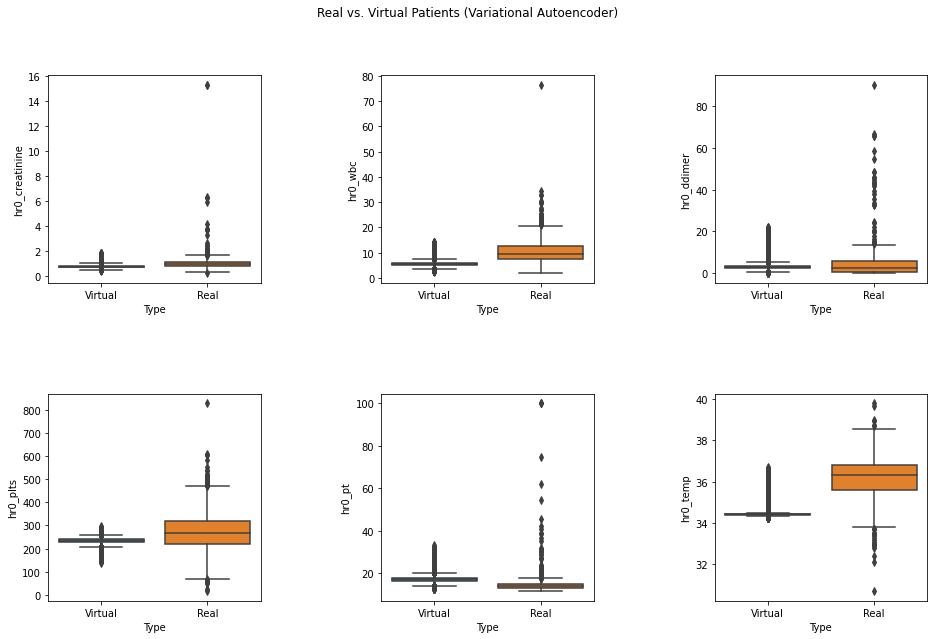

In [ ]:
# feature_list = ['hr0_temp', 'hr0_hr', 'hr0_factorii', 'hr0_factorv', 'hr0_factorx', 'hr0_plts']
data_real = trauma_data[Interest_features]
data_virtual = pd.concat([result_0, result_1])[Interest_features]

data_real['Type'] = 'Real'
data_virtual['Type'] = 'Virtual'
cdf = pd.concat([data_virtual, data_real])

fig, axs = plt.subplots(2,3, figsize=(15, 10))

for i, feature in enumerate(Interest_features):
  sns.boxplot(x='Type', y=feature, data=cdf, orient='v', ax=axs[i//3][i%3])

fig.suptitle('Real vs. Virtual Patients (Variational Autoencoder)')
fig.tight_layout(pad=8)
# fig.savefig('gdrive/MyDrive/VAE_seaborn_vis.png')
plt.show()

In [ ]:
desire_stat = ['mean', 'std', '25%', '50%', '75%']

for feature in Interest_features:

  dis1 = trauma_data[feature].describe()
  dis2 = data_virtual[feature].describe()

  data = np.hstack([dis1.values, dis2.values])
  table = pd.DataFrame(index=['real', 'virtual'], columns=dis1.index, data=data.reshape(2, 8))
  table.columns.name = feature
  print(table[desire_stat].to_markdown())
  print('\n\n')

|         |     mean |      std |      25% |      50% |      75% |
|:--------|---------:|---------:|---------:|---------:|---------:|
| real    | 1.03964  | 0.725248 | 0.8      | 0.95     | 1.14     |
| virtual | 0.874792 | 0.408296 | 0.670547 | 0.738503 | 0.818784 |



|         |     mean |     std |     25% |     50% |      75% |
|:--------|---------:|--------:|--------:|--------:|---------:|
| real    | 10.6087  | 4.9821  | 7.4     | 9.6     | 12.8     |
| virtual |  6.52265 | 2.71274 | 5.05021 | 5.57811 |  5.93195 |



|         |    mean |     std |     25% |     50% |     75% |
|:--------|--------:|--------:|--------:|--------:|--------:|
| real    | 4.53939 | 7.22526 | 0.735   | 2.60323 | 6.055   |
| virtual | 4.39559 | 3.79947 | 2.34067 | 3.13265 | 4.06245 |



|         |    mean |     std |     25% |     50% |     75% |
|:--------|--------:|--------:|--------:|--------:|--------:|
| real    | 272.821 | 84.7272 | 220     | 269     | 320.066 |
| virtual | 233.442 | 13.4454 | 2

|         |     mean |      std |      25% |      50% |      75% |
|:--------|---------:|---------:|---------:|---------:|---------:|
| real    | 1.03964  | 0.725248 | 0.8      | 0.95     | 1.14     |
| virtual | 0.874792 | 0.408296 | 0.670547 | 0.738503 | 0.818784 |



|         |     mean |     std |     25% |     50% |      75% |
|:--------|---------:|--------:|--------:|--------:|---------:|
| real    | 10.6087  | 4.9821  | 7.4     | 9.6     | 12.8     |
| virtual |  6.52265 | 2.71274 | 5.05021 | 5.57811 |  5.93195 |



|         |    mean |     std |     25% |     50% |     75% |
|:--------|--------:|--------:|--------:|--------:|--------:|
| real    | 4.53939 | 7.22526 | 0.735   | 2.60323 | 6.055   |
| virtual | 4.39559 | 3.79947 | 2.34067 | 3.13265 | 4.06245 |



|         |    mean |     std |     25% |     50% |     75% |
|:--------|--------:|--------:|--------:|--------:|--------:|
| real    | 272.821 | 84.7272 | 220     | 269     | 320.066 |
| virtual | 233.442 | 13.4454 | 228.236 | 233.936 | 238.808 |



|         |    mean |     std |     25% |     50% |     75% |
|:--------|--------:|--------:|--------:|--------:|--------:|
| real    | 15.0198 | 5.83068 | 13.2    | 13.9    | 15      |
| virtual | 18.5678 | 4.43007 | 16.2367 | 17.3569 | 18.2452 |



|         |    mean |      std |     25% |     50% |     75% |
|:--------|--------:|---------:|--------:|--------:|--------:|
| real    | 36.1544 | 0.92899  | 35.6    | 36.3274 | 36.8    |
| virtual | 34.6162 | 0.387822 | 34.4064 | 34.4455 | 34.5042 |

**Use GDA to generate data**

In [ ]:
# GDA model
# MAP
from scipy.stats import multivariate_normal as mvn
class GDA:
    def __init__(self, x_train, y_train):
        assert x_train.shape[0] == y_train.shape[0]
        self.n = x_train.shape[0]    # The number of training points
        self.p = x_train.shape[1] # The dimension of the data (number of features)
        self.x_train = x_train # Training features
        self.y_train = y_train # Training labels (either 0 or 1)
        
        # Parameters that need to be fit.
        self.mu0 = None
        self.mu1 = None
        self.Sigma = None
        self.phi = None
    
    def fit(self):

        X = self.x_train
        y = self.y_train
        n = self.n
        p = self.p
        
        self.phi = np.mean(y)
        self.mu0 = np.mean(X[y == 0], axis=0)
        self.mu1 = np.mean(X[y == 1], axis=0)
        
        N_x0 = X[y == 0] - self.mu0
        N_x1 = X[y == 1] - self.mu1
        self.Sigma = (np.dot(N_x0.T, N_x0) + 
                      np.dot(N_x1.T, N_x1))/self.n
    
    def predict(self, x_test):

        rv0 = mvn.pdf(x_test, self.mu0, self.Sigma)*(1-self.phi)
        rv1 = mvn.pdf(x_test, self.mu1, self.Sigma)*self.phi
        y_pred = rv1 > rv0
        y_pred = y_pred.astype(np.int32)
        return y_pred
    def predict_prob(self, x_test):
        rv0 = mvn.pdf(x_test, self.mu0, self.Sigma)*(1-self.phi)
        rv1 = mvn.pdf(x_test, self.mu1, self.Sigma)*self.phi
        return (rv0, rv1)
    def sample(self, label, n_samples):
        if (label == 0):
            x_sampled = mvn.rvs(mean=self.mu0, cov=self.Sigma, size=n_samples)
        else:
            x_sampled = mvn.rvs(mean=self.mu1, cov=self.Sigma, size=n_samples)        
        return x_sampled

In [ ]:
#test QuadraticDiscriminantAnalysis
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# clf = QuadraticDiscriminantAnalysis()
# clf.fit(X_train, y_train)
# y_pred = gda.predict(X_test)
# acc_gda = accuracy_score(y_pred, y_test)
# print(f'mean accuracy is {acc_gda * 100}')
# print(confusion_matrix(y_pred, y_test))
# print('auc score: ', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

# gda = GDA(X_train, y_train)
# gda.fit()

# roc_auc_score(y_test, gda.predict_prob(X_test)[1])

0.7034098617985356

In [ ]:
#GDA baseline
# X_train, X_test, y_train, y_test = train_test_split(original_df.loc[:, X.columns != 'Mortality'], y, test_size=0.3, random_state=0)
X_train = trauma_data.drop(columns='Mortality')
y_train = trauma_data.Mortality
X_test = final_test_set.drop(columns='Mortality')
y_test = final_test_set.Mortality
gda = GDA(X_train, y_train)
gda.fit()

y_pred = gda.predict(X_test)
acc_gda = accuracy_score(y_pred, y_test)
print(f'mean accuracy is {acc_gda * 100}')
print(confusion_matrix(y_pred, y_test))

print('auc score: ', roc_auc_score(y_test, gda.predict_prob(X_test)[1]))

mean accuracy is 95.28619528619528
[[233   5]
 [  9  50]]
auc score:  0.7654395191585274


In [ ]:
#(Test)
#GDA baseline
# X_train, X_test, y_train, y_test = train_test_split(original_df.loc[:, X.columns != 'Mortality'], y, test_size=0.3, random_state=0)
X_train = trauma_data.drop(columns='Mortality')
y_train = trauma_data.Mortality
X_test = final_test_set.drop(columns='Mortality')
y_test = final_test_set.Mortality

x = X_train.values #returns a numpy array
min_max_scaler_t = MinMaxScaler()
x_scaled = min_max_scaler_t.fit_transform(x)
X_train = pd.DataFrame(x_scaled)
X_train.columns = trauma_data.drop(columns='Mortality').columns

x = X_test.values #returns a numpy array
min_max_scaler_t = MinMaxScaler()
x_scaled = min_max_scaler_t.fit_transform(x)
X_test = pd.DataFrame(x_scaled)
X_test.columns = trauma_data.drop(columns='Mortality').columns

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

gda = GDA(X_train, y_train)
gda.fit()

y_pred = gda.predict(X_test)
acc_gda = accuracy_score(y_pred, y_test)
print(f'mean accuracy is {acc_gda * 100}')
print(confusion_matrix(y_pred, y_test))

print('auc score: ', roc_auc_score(y_test, gda.predict_prob(X_test)[1]))

mean accuracy is 94.27609427609428
[[229   4]
 [ 13  51]]
auc score:  0.5262960180315552


0       0
1       0
2       0
3       0
4       0
       ..
1182    0
1183    0
1184    1
1185    0
1186    0
Name: Mortality, Length: 1187, dtype: int64

In [ ]:
class_1_samples = gda.sample(label=1, n_samples=100000)
class_1_samples_df = pd.DataFrame(data=class_1_samples, columns=trauma_data.columns.drop('Mortality'))
class_0_samples = gda.sample(label=0, n_samples=100000)
class_0_samples_df = pd.DataFrame(data=class_0_samples, columns=trauma_data.columns.drop('Mortality'))
#Add outcome column and merge class0 and class1 dfs
class_1_samples_df['Mortality'] = 1
class_0_samples_df['Mortality'] = 0
hr0_virtual_data = pd.concat([class_1_samples_df, class_0_samples_df])
# hr0_virtual_data.hist(bins=20, figsize=(20,10))

(Test) remove the negative values By compressing towards median

In [ ]:
trauma_data

,hr0_temp,hr0_hr,hr0_resprate,hr0_sbp,hr0_ph,hr0_bun,hr0_creatinine,hr0_wbc,hr0_hgb,hr0_hct,hr0_factorii,hr0_factorv,hr0_factorx,hr0_tfpi,hr0_ddimer,hr0_pt,hr0_ptt,hr0_inr,hr0_plts,Mortality
481,37.000000,91.0,18.000000,146.0,7.309521,22.0,1.15,11.800000,14.300000,45.799999,59.000000,49.000000,60.000000,11.602107,0.470000,13.600000,27.500000,1.1,315.000000,0
879,37.000000,72.0,20.000000,154.0,7.330000,16.0,0.93,24.000000,16.400000,48.099998,73.000000,32.000000,78.000000,18.141694,8.480000,13.200000,22.900000,1.0,359.000000,0
319,36.099998,87.0,19.000000,127.0,7.320000,22.0,0.89,11.200000,14.600000,40.500000,96.000000,47.000000,88.000000,17.360314,4.580000,13.200000,29.000000,1.1,196.000000,0
1128,36.977118,80.0,22.000000,117.0,7.420000,16.0,0.79,10.300000,14.600000,43.299999,77.933403,53.529777,79.870080,13.251646,2.709103,11.700000,24.500000,0.9,286.000000,0
58,36.500000,66.0,16.000000,130.0,7.360000,23.0,1.14,10.800000,12.800000,38.200001,64.000000,72.000000,89.000000,11.600000,0.100000,13.700000,29.400000,1.0,213.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,36.748248,145.0,28.000000,153.0,7.200000,12.0,1.04,18.200001,10.500000,31.799999,57.000000,17.000000,53.000000,17.685015,10.950000,17.000000,39.500000,1.4,238.000000,0
835,36.739322,50.0,17.453979,105.0,7.310000,10.0,0.71,8.700000,15.500000,42.900002,74.000000,79.000000,83.000000,11.550689,4.040000,12.300000,32.000000,0.9,216.000000,0
1216,36.599998,120.0,21.000000,105.0,7.220000,42.0,1.83,16.799999,13.700000,41.000000,54.041684,26.701475,58.229739,36.514264,10.235785,19.200001,71.300003,1.5,234.000000,1
559,37.200001,104.0,17.000000,134.0,7.312862,8.0,0.79,11.600000,13.500000,42.099998,81.179778,54.104003,83.967302,13.939033,1.479064,13.500000,28.100000,1.1,433.000000,0


In [ ]:
#Try standardize x\in[0, 1]


# x = hr0_virtual_data.values #returns a numpy array
# min_max_scaler = MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df_v = pd.DataFrame(x_scaled)
# df_v.columns = trauma_data.columns

# xx = data_real.values #returns a numpy array
# min_max_scaler_1 = MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df_r = pd.DataFrame(x_scaled)
# df_r.columns = trauma_data.columns

# df_v['Type'] = 'Virtual'
# df_r['Type'] = 'Real'

# cdf = pd.concat([df_v, df_r])

# fig, axs = plt.subplots(2,3, figsize=(15, 10))

# for i, feature in enumerate(Interest_features):
#   sns.boxplot(x='Type', y=feature, data=cdf, orient='v', ax=axs[i//3][i%3])
# fig.suptitle('Real vs. Virtual Patients (Gaussian Discriminant Analysis)')
# fig.tight_layout(pad=8)
# # fig.savefig('gdrive/MyDrive/GDA_seaborn_vis.png')
# plt.show()


# hr0_virtual_data = df_v

In [ ]:
for i, feature in enumerate(hr0_virtual_data.drop(columns='Mortality').columns):
  m = hr0_virtual_data[feature].mean()
  hr0_virtual_data.sort_values(by=feature, inplace=True)
  hr0_virtual_data.reset_index(drop=True, inplace=True)
  for j, num in enumerate(hr0_virtual_data[feature]):
    if num >= 0:
      break
    elif num < 0:
      hr0_virtual_data.iloc[j, i] -= num
      hr0_virtual_data.iloc[-j-1, i] += num

In [ ]:
# hr0_virtual_data.sort_values(by='hr0_temp', inplace=True)
# hr0_virtual_data.reset_index(drop=True, inplace=True)
# hr0_virtual_data.iloc[-1, 0]

149.88777170991602

In [ ]:
hr0_virtual_data.describe()

,hr0_temp,hr0_hr,hr0_resprate,hr0_sbp,hr0_ph,hr0_bun,hr0_creatinine,hr0_wbc,hr0_hgb,hr0_hct,hr0_factorii,hr0_factorv,hr0_factorx,hr0_tfpi,hr0_ddimer,hr0_pt,hr0_ptt,hr0_inr,hr0_plts,Mortality
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,35.870101,98.843941,20.073080,138.186648,7.276136,17.034615,1.101920,11.093166,13.242655,39.759302,68.587790,45.098540,70.441048,21.371351,6.878316,16.589604,35.797382,1.420836,258.082997,0.500000
std,0.971039,24.777473,6.338909,32.342058,0.121074,8.602722,0.645000,4.886358,2.065580,5.857039,18.890743,22.325415,21.439497,9.743218,5.151677,6.009938,14.553751,0.725916,85.844224,0.500001
min,31.332491,0.000000,0.000000,0.000000,6.730928,0.000000,0.000000,0.000000,4.275403,14.206641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.208109,82.219131,15.804141,116.333851,7.194112,10.900210,0.609695,7.724882,11.844980,35.804205,55.843384,29.213401,55.907759,13.327458,1.670158,12.478900,25.711787,0.899230,199.761069,0.000000
50%,35.871264,98.829477,20.061259,138.150116,7.276401,17.036864,1.101274,11.090823,13.250375,39.780795,68.585227,45.072114,70.454484,21.376295,6.875554,16.598415,35.813414,1.421667,258.093191,0.500000
75%,36.535365,115.550282,24.347958,160.019280,7.357950,23.181531,1.593285,14.456107,14.644815,43.721879,81.358662,61.007579,85.012435,29.413907,12.079969,20.695017,45.948309,1.942709,316.123835,1.000000
max,39.796601,197.223196,42.007452,280.668003,7.882969,35.728800,2.427128,22.563478,22.212965,68.154034,143.519994,91.792150,140.744427,43.614514,13.844722,35.771197,74.122035,3.055905,524.397245,1.000000


**visualize and compare each variable distribution of VAE-generated patients**

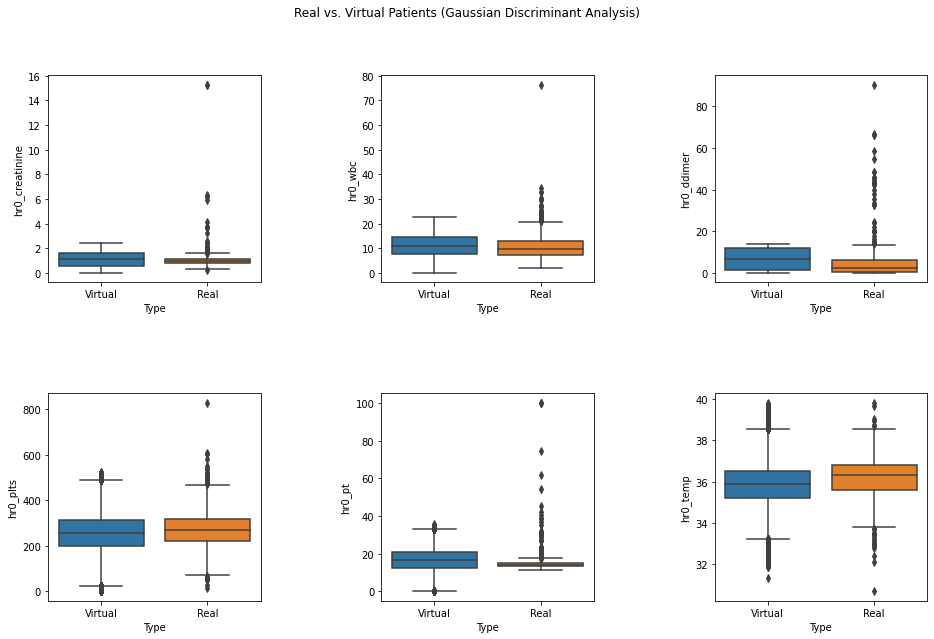

In [ ]:
hr0_virtual_data['Type'] = 'Virtual'
cdf = pd.concat([hr0_virtual_data, data_real])

fig, axs = plt.subplots(2,3, figsize=(15, 10))

for i, feature in enumerate(Interest_features):
  sns.boxplot(x='Type', y=feature, data=cdf, orient='v', ax=axs[i//3][i%3])
fig.suptitle('Real vs. Virtual Patients (Gaussian Discriminant Analysis)')
fig.tight_layout(pad=8)
fig.savefig('gdrive/MyDrive/GDA_seaborn_vis.png')
plt.show()

In [ ]:
hr0_virtual_data.drop(columns='Type', inplace=True)

In [ ]:
def gda_result(X_train, y_train, X_test, y_test):
  gda = GDA(X_train, y_train)
  gda.fit()
  y_pred = gda.predict(X_test)
  acc_vir_ba_gcd = accuracy_score(y_test, y_pred)
  print(f'mean accuracy is {acc_vir_ba_gcd * 100}')
  print(confusion_matrix(y_test, y_pred))

  print('auc score: ', roc_auc_score(y_test, gda.predict_prob(X_test)[1]))

In [ ]:
# GDA train on virtual data test on real data (GDA generated)
X_train = hr0_virtual_data.drop(columns='Mortality')
y_train = hr0_virtual_data.Mortality
X_test = original_df.drop(columns='Mortality')
y_test = original_df.Mortality
gda_result(X_train, y_train, X_test, y_test)

mean accuracy is 96.63072776280323
[[1185   28]
 [  22  249]]
auc score:  0.6955978133565341


In [ ]:
y_train.value_counts()

1    100000
0    100000
Name: Mortality, dtype: int64

In [ ]:
# GDA train on real+virtual data test on real data (GDA generated)
X_train = pd.concat([hr0_virtual_data.drop(columns='Mortality'), trauma_data.drop(columns='Mortality')])
y_train = pd.concat([hr0_virtual_data.Mortality, trauma_data.Mortality])
X_test = final_test_set.drop(columns='Mortality')
y_test = final_test_set.Mortality
gda_result(X_train, y_train, X_test, y_test)

mean accuracy is 95.28619528619528
[[233   9]
 [  5  50]]
auc score:  0.7498121712997745


In [ ]:
# GDA train on virtual data and test on real data (VAE generated)
X_train = pd.concat([result_0.drop(columns='Mortality'), result_1.drop(columns='Mortality')])
y_train = pd.concat([result_0.Mortality, result_1.Mortality])
X_test = original_df.drop(columns='Mortality')
y_test = original_df.Mortality
gda_result(X_train, y_train, X_test, y_test)

mean accuracy is 81.73854447439352
[[1213    0]
 [ 271    0]]
auc score:  0.5


In [ ]:
# GDA train on real+virtual data test on real data (VAE generated)
X_train = pd.concat([result_0.drop(columns='Mortality'), result_1.drop(columns='Mortality'), trauma_data.drop(columns='Mortality')])
y_train = pd.concat([result_0.Mortality, result_1.Mortality, trauma_data.Mortality])
X_test = final_test_set.drop(columns='Mortality')
y_test = final_test_set.Mortality
gda_result(X_train, y_train, X_test, y_test)

mean accuracy is 88.21548821548821
[[232  10]
 [ 25  30]]
auc score:  0.49962434259954913


In [ ]:
for feature in Interest_features:

  dis1 = data_real[feature].describe()
  dis2 = hr0_virtual_data[feature].describe()

  data = np.hstack([dis1.values, dis2.values])
  table = pd.DataFrame(index=['real', 'virtual'], columns=dis1.index, data=data.reshape(2, 8))
  table.columns.name = feature
  print(table[desire_stat].to_markdown())
  print('\n\n')

NameError: ignored

|         |    mean |      std |      25% |     50% |     75% |
|:--------|--------:|---------:|---------:|--------:|--------:|
| real    | 1.03964 | 0.725248 | 0.8      | 0.95    | 1.14    |
| virtual | 1.10192 | 0.645    | 0.609695 | 1.10127 | 1.59329 |



|         |    mean |     std |     25% |     50% |     75% |
|:--------|--------:|--------:|--------:|--------:|--------:|
| real    | 10.6087 | 4.9821  | 7.4     |  9.6    | 12.8    |
| virtual | 11.0932 | 4.88636 | 7.72488 | 11.0908 | 14.4561 |



|         |    mean |     std |     25% |     50% |    75% |
|:--------|--------:|--------:|--------:|--------:|-------:|
| real    | 4.53939 | 7.22526 | 0.735   | 2.60323 |  6.055 |
| virtual | 6.87832 | 5.15168 | 1.67016 | 6.87555 | 12.08  |



|         |    mean |     std |     25% |     50% |     75% |
|:--------|--------:|--------:|--------:|--------:|--------:|
| real    | 272.821 | 84.7272 | 220     | 269     | 320.066 |
| virtual | 258.083 | 85.8442 | 199.761 | 258.093 | 316.124 |



|         |    mean |     std |     25% |     50% |    75% |
|:--------|--------:|--------:|--------:|--------:|-------:|
| real    | 15.0198 | 5.83068 | 13.2    | 13.9    | 15     |
| virtual | 16.5896 | 6.00994 | 12.4789 | 16.5984 | 20.695 |



|         |    mean |      std |     25% |     50% |     75% |
|:--------|--------:|---------:|--------:|--------:|--------:|
| real    | 36.1544 | 0.92899  | 35.6    | 36.3274 | 36.8    |
| virtual | 35.8701 | 0.971039 | 35.2081 | 35.8713 | 36.5354 |

In [ ]:
results_1[2].hist(bins=20, figsize=(15,8))

In [ ]:
df_class_1.hist(bins=20, figsize=(20,10))

**Use Lasso logistic regression to test with virtual patients (GDA and VAE)**

In [ ]:
from sklearn.linear_model import Lasso
def lasso_result(X_train, y_train, X_test, y_test):

  lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train) 
  y_pred = lasso001.predict(X_test)
  m = y_pred.mean()
  new_y_pred = []
  for p in y_pred:
    if p < m:
      new_y_pred.append(0)
    else:
      new_y_pred.append(1)
  y_pred = [0 for rst in y_pred if rst < m else 1]
  acc_vir_ba_gcd = accuracy_score(y_test, y_pred)

  
  # print("Training set score: {:.2f}".format(lasso001.score(X_train, y_train))) 
  # print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test))) 
  # print("Number of features used: {}".format(np.sum(lasso001.coef_ != 0)))
  print(f'mean accuracy is {acc_vir_ba_gcd * 100}')
  print(confusion_matrix(y_test, y_pred))

  # print('auc score: ', roc_auc_score(y_test, gda.predict_prob(X_test)[1]))

SyntaxError: ignored

In [ ]:
X_train = trauma_data.drop(columns='Mortality')
y_train = trauma_data.Mortality
X_test = final_test_set.drop(columns='Mortality')
y_test = final_test_set.Mortality
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)
lasso001.predict(X_test).mean()

0.19310456620214714

In [ ]:
# Lasso baseline on real
X_train = trauma_data.drop(columns='Mortality')
y_train = trauma_data.Mortality
X_test = final_test_set.drop(columns='Mortality')
y_test = final_test_set.Mortality
lasso_result(X_train, y_train, X_test, y_test)

ValueError: ignored

In [ ]:
# Lasso train on virtual data test on real data (GDA generated)
X_train = hr0_virtual_data.drop(columns='Mortality')
y_train = hr0_virtual_data.Mortality
X_test = original_df.drop(columns='Mortality')
y_test = original_df.Mortality
lasso_result(X_train, y_train, X_test, y_test)

Training set score: 0.81
Test set score: 0.65
Number of features used: 12


In [ ]:
# GDA train on real+virtual data test on real data (GDA generated)
X_train = pd.concat([hr0_virtual_data.drop(columns='Mortality'), trauma_data.drop(columns='Mortality')])
y_train = pd.concat([hr0_virtual_data.Mortality, trauma_data.Mortality])
X_test = final_test_set.drop(columns='Mortality')
y_test = final_test_set.Mortality
lasso_result(X_train, y_train, X_test, y_test)

Training set score: 0.81
Test set score: 0.53
Number of features used: 12


In [ ]:
# GDA train on virtual data and test on real data (VAE generated)
X_train = pd.concat([result_0.drop(columns='Mortality'), result_1.drop(columns='Mortality')])
y_train = pd.concat([result_0.Mortality, result_1.Mortality])
X_test = original_df.drop(columns='Mortality')
y_test = original_df.Mortality
lasso_result(X_train, y_train, X_test, y_test)

Training set score: 0.99
Test set score: -0.81
Number of features used: 9


In [ ]:
# GDA train on real+virtual data test on real data (VAE generated)
X_train = pd.concat([result_0.drop(columns='Mortality'), result_1.drop(columns='Mortality'), trauma_data.drop(columns='Mortality')])
y_train = pd.concat([result_0.Mortality, result_1.Mortality, trauma_data.Mortality])
X_test = final_test_set.drop(columns='Mortality')
y_test = final_test_set.Mortality
lasso_result(X_train, y_train, X_test, y_test)

Training set score: 0.98
Test set score: -0.03
Number of features used: 10


**Use Random Forest Model to test usefulness of the generated data**

In [ ]:
# Random Forest Model - Cross Validate
rfc = RandomForestClassifier(n_estimators= 500, class_weight='balanced')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
#RFC cv on real
X = original_df.drop(columns='Mortality')
y = original_df.Mortality
scores = cross_val_score(rfc, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
scores = cross_val_score(rfc, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
print('Mean auc: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
# RFC train on virtual data test on real data (GDA generated)
X_train = hr0_virtual_data.drop(columns='Mortality')
y_train = hr0_virtual_data.Mortality
X_test = original_df.drop(columns='Mortality')
y_test = original_df.Mortality
rfc = RandomForestClassifier(n_estimators= 500, class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
acc_ba_vir_gcd = accuracy_score(y_test, y_pred)
print(f'mean accuracy is {acc_ba_vir_gcd}')
# print(confusion_matrix(y_test, y_pred))
print('Mean auc: %.3f' % roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]))

mean accuracy is 0.9609164420485176
Mean auc: 0.982


In [ ]:
# RFC train on virtual data test on real data (VAE generated)
X_train = pd.concat([result_0.drop(columns='Mortality'), result_1.drop(columns='Mortality')])
y_train = pd.concat([result_0.Mortality, result_1.Mortality])
X_test = original_df.drop(columns='Mortality')
y_test = original_df.Mortality
rfc = RandomForestClassifier(n_estimators= 500, class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
acc_ba_vir_gcd = accuracy_score(y_test, y_pred)
print(f'mean accuracy is {acc_ba_vir_gcd}')
# print(confusion_matrix(y_test, y_pred))
print('Mean auc: %.3f' % roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]))

mean accuracy is 0.29245283018867924
Mean auc: 0.853


In [ ]:
1 - 0.292452830

0.70754717

In [ ]:
# RFC train on real+virtual data test on real data (GDA generated)
X_train = pd.concat([hr0_virtual_data.drop(columns='Mortality'), trauma_data.drop(columns='Mortality')])
y_train = pd.concat([hr0_virtual_data.Mortality, trauma_data.Mortality])
X_test = final_test_set.drop(columns='Mortality')
y_test = final_test_set.Mortality
rfc = RandomForestClassifier(n_estimators= 500, class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
acc_ba_vir_gcd = accuracy_score(y_test, y_pred)
print(f'mean accuracy is {acc_ba_vir_gcd}')
# print(confusion_matrix(y_test, y_pred))
print('Mean auc: %.3f' % roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]))

mean accuracy is 0.9427609427609428
Mean auc: 0.955


In [ ]:
# RFC train on real+virtual data test on real data (VAE generated)
X_train = pd.concat([result_0.drop(columns='Mortality'), result_1.drop(columns='Mortality'), trauma_data.drop(columns='Mortality')])
y_train = pd.concat([result_0.Mortality, result_1.Mortality, trauma_data.Mortality])
X_test = final_test_set.drop(columns='Mortality')
y_test = final_test_set.Mortality
rfc = RandomForestClassifier(n_estimators= 500, class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
acc_ba_vir_gcd = accuracy_score(y_test, y_pred)
print(f'mean accuracy is {acc_ba_vir_gcd}')
# print(confusion_matrix(y_test, y_pred))
print('Mean auc: %.3f' % roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]))

mean accuracy is 0.9292929292929293
Mean auc: 0.965


Cross-val on partial trauma_data

Cross-val

Train/Test: real dataset ~ 1400 samples

In [ ]:
# classify 
X_train = trauma_data.loc[:, trauma_data.columns != 'Mortality']
y_train = trauma_data['Mortality']
X_test = final_test_set.loc[:, trauma_data.columns != 'Mortality']
y_test = final_test_set['Mortality']
model = RandomForestClassifier(n_estimators= 500, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'mean accuracy is {accuracy_score(y_pred, y_test)}')
print(confusion_matrix(y_pred, y_test))
# classify with cross-val
X = pd.concat([trauma_data, final_test_set])
y = X['Mortality']
scores = cross_val_score(model, X.loc[:, X.columns != 'Mortality'], y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
real_score = mean(scores)
print('Mean Accuracy: %.3f (%.3f)' % (real_score, std(scores)))

mean accuracy is 0.9259259259259259
[[232  12]
 [ 10  43]]
Mean Accuracy: 0.958 (0.015)


single prediction

Train: real+virtual ~ 120,000 samples

Test: initial_test_set (real)

In [ ]:
X_train = combined_df_inbalanced.loc[:, combined_df_inbalanced.columns != 'Mortality']
y_train = combined_df_inbalanced['Mortality']
X_test = final_test_set.loc[:, combined_df_inbalanced.columns != 'Mortality']
y_test = final_test_set['Mortality']
tic = time.clock()
model = RandomForestClassifier(n_estimators= 500, class_weight='balanced')
model.fit(X_train, y_train)
tok = time.clock()
y_pred = model.predict(X_test)
acc_inba_vir_vae = accuracy_score(y_pred, y_test)
print(f'mean accuracy is {acc_inba_vir_vae}')
print(confusion_matrix(y_pred, y_test))

print(f'fit time: {tok - tic}')

mean accuracy is 0.9326599326599326
[[232  10]
 [ 10  45]]
fit time: 143.215625


Train with a balanced generated dataset

In [ ]:
# make a balanced dataset
total_nums_1 = ((100000 - n_1) // x_test_1.shape[0]) + 1
result_1 = vae_generate(vae_1, x_test_1, 1, total_nums = total_nums_1)
combined_df_balanced = pd.concat([trauma_data, result_0, result_1])

In [ ]:
combined_df_balanced.shape

(200171, 20)

single prediction

Train: real+virtual ~ 200,000 samples (balanced)

Test: initial_test_set (real)

In [ ]:
X_train = combined_df_balanced.loc[:, combined_df_balanced.columns != 'Mortality']
y_train = combined_df_balanced['Mortality']
X_test = final_test_set.loc[:, combined_df_balanced.columns != 'Mortality']
y_test = final_test_set['Mortality']
tic = time.clock()
model = RandomForestClassifier(n_estimators= 500, class_weight='balanced')
model.fit(X_train, y_train)
tok = time.clock()
y_pred = model.predict(X_test)
acc_ba_vir_vae = accuracy_score(y_pred, y_test)
print(f'mean accuracy is {acc_ba_vir_vae}')
print(confusion_matrix(y_pred, y_test))

print(f'fit time: {tok - tic}')

mean accuracy is 0.9326599326599326
[[232  10]
 [ 10  45]]
fit time: 307.362039


In [ ]:
# trauma_data = pd.read_excel('gdrive/MyDrive/SF_IMPUTED.xlsx')
# trauma_data.drop(columns='hr0_ptt.1', inplace=True)

# features = ['hr0_temp', 'hr0_resprate', 'hr0_bun', 'hr0_creatinine', 'hr0_pt', 'hr0_ptt', 'hr0_inr']
# for f in features:
#   trauma_data[f] = np.log(trauma_data[f])

In [ ]:
# class_0_samples_df.to_csv('./gdrive/MyDrive/Mortality_0_Virtual_Patients.csv', index=False)

**Visualize Accuracy with different methods**

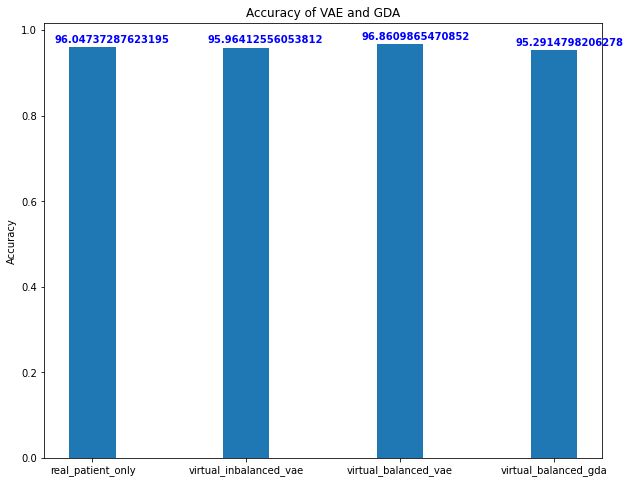

In [ ]:
x = ['real_patient_only', 'virtual_inbalanced_vae', 'virtual_balanced_vae', 'virtual_balanced_gda']
y = [real_score, acc_inba_vir_vae, acc_ba_vir_vae, acc_ba_vir_gcd]
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('Accuracy of VAE and GDA')
ax.bar(x, y, width=0.3)
ax.set_xticks(np.arange(4))
ax.set_xticklabels(x)
ax.set_ylabel('Accuracy')
for i, v in enumerate(y):
    ax.text(i-0.25, v + 0.01, float(v)*100, color='blue', fontweight='bold')
fig.show()